이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [2]:
# Fashion MNINST 데이터셋 불러오기
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [3]:
# 결측치 여부
missing_values = np.isnan(train_images).sum()
print(f"결측치가 존재하는 이미지: {missing_values}")

# 이미지 크기
image_shape = train_images.shape[1:]
print(f"이미지 크기: {image_shape}")

# label 별 이미지 개수
unique_labels, counts = np.unique(train_labels, return_counts=True)
summary = dict(zip(unique_labels, counts))
print(f"라벨별 이미지 개수 요약: {summary}")

결측치가 존재하는 이미지: 0
이미지 크기: (28, 28)
라벨별 이미지 개수 요약: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


### Data중 첫 번째 이미지를 보여주세요.

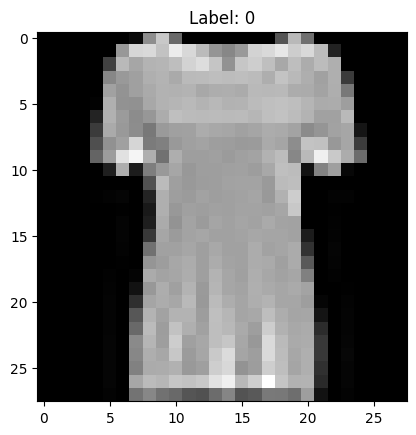

In [4]:
plt.imshow(train_images[10], cmap='gray')
plt.title(f"Label: {train_labels[10]}")
plt.show()
# train_images[0]

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [5]:
# 이미지 데이터를 4차원 텐서로 변환
train_x = train_images.reshape(-1, 28*28)
test_x = test_images.reshape(-1, 28*28)

print(f"Train images shape after reshaping: {train_x.shape}")
print(f"Test images shape after reshaping: {test_x.shape}")

Train images shape after reshaping: (60000, 784)
Test images shape after reshaping: (10000, 784)


In [6]:
train_x[1]
test_x[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  13,  67,   0,
         0,   0,   0,  50,  38,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   8, 120, 209, 226,
       247, 237, 255, 255, 255, 247, 238, 235, 172,  72,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 137, 239, 252,
       243, 234, 229, 238, 244, 246, 240, 230, 232, 239, 248, 251, 194,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102, 255,
       231, 228, 227, 228, 233, 230, 230, 229, 228, 232, 232, 231, 227,
       224, 252, 179,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       233, 241, 229, 231, 255, 255, 238, 231, 227, 238, 246, 228, 230,
       227, 234, 235, 229, 241,  20,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 248, 241, 231, 255, 149,  47, 252, 228, 255, 242, 216,
       238, 232, 255, 228, 220, 234, 250,  54,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 255, 240, 232, 255,  15,   0, 255, 23

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [7]:
# 모든 데이터가 0~1사이 값 갖도록 함
train_x = train_x/255.0
test_x = test_x/255.0
train_x[2]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.08627451,
       0.4627451 , 0.09411765, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18823529, 0.34509804, 0.01960784,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04705882, 0.39215686, 0.83137255, 0.80392157,
       0.7254902 , 0.70196078, 0.67843137, 0.72941176, 0.75686275,
       0.86666667, 0.55686275, 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33333333, 0.29803922, 0.78039216, 0.88235294, 0.97254902,
       1.        , 0.93333333, 0.88627451, 0.61568627, 0.26666

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [8]:
train_x.shape


(60000, 784)

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

PCA(주성분 분석)은 데이터의 분산을 최대한 보존하는 것으로 목표로 두고 차원 축소를 시도한다. 차원 축소를 시도할 때는 선형 변환을 사용해 원본 데이터의 주성분(가장 큰 분산을 가지는 축)을 찾아낸다.  
 PCA는 계산이 상대적으로 빠르기에 대규모 데이터셋에 적용하기 용이하다.   
 선형 데이터에는 적합하나 비선형 구조는 잘 찾아내지 못한다. 

 반면 t-SNE는 고차원 데이터를 저차원으로 변환하여 데이터의 클러스터링 구조를 시각화하는데 초점을 두고 있다. t-SNE를 사용하면 높은 차원 공간에서 비슷한 데이터 구조는 낮은 차원 공간에서 가깝게 대응하며, 비슷하지 않은 데이터 구조는 멀리 떨어져 대응된다.  
t-SNE는 비선형적인 방법의 차원 축소 방법이다. 

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
def pca_transform(X, n_components=50):
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # 데이터 재구성
    X_reconstructed = pca.inverse_transform(X_pca)
    
    return X_pca, pca, X_reconstructed

# 데이터를 2D에서 1D로 
X_train_flattened = train_x.reshape(-1, 28 * 28)

# PCA 변환 함수 적용
X_pca_50, pca_obj, X_reconstructed = pca_transform(X_train_flattened)

print(f"원본 데이터 형태: {X_train_flattened.shape}")
print(f"PCA를 적용한 데이터 형태: {X_pca_50.shape}")

원본 데이터 형태: (60000, 784)
PCA를 적용한 데이터 형태: (60000, 50)


In [11]:
X_pca_50[2]  

array([-2.846709  , -4.32093387,  0.41629115,  0.82365373, -0.41224713,
       -0.20947938, -0.00817981,  0.20119466, -0.35757363, -0.32577027,
        0.43675605, -0.3562613 ,  0.40176411, -0.34924048, -0.36717945,
       -0.20601862, -0.15995207,  0.23985074,  0.43046319, -0.20669446,
        0.91840611,  0.32958125, -0.19927355,  0.018071  ,  0.36907252,
        0.36211174, -0.14456343, -0.45328431,  0.30002011,  0.41360586,
       -0.42621176,  0.45892831,  0.40168127, -0.34463689,  0.32456217,
       -0.58390907, -0.15391984,  0.60830423,  0.17309056, -0.07280508,
       -0.1068077 ,  0.48118596,  0.2543699 , -0.27854699, -0.26888076,
        0.07996793,  0.18569026, -0.0360864 ,  0.10233847, -0.11734707])

### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [12]:
# 설명된 분산 비율 출력
explained_variance_ratio = pca_obj.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}")

Explained variance ratio: [0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267 0.00992875 0.00913255
 0.00765793 0.00659706 0.00607851 0.00589821 0.00551934 0.005245
 0.00458079 0.00455515 0.00433684 0.00407097 0.00384758 0.00372551
 0.00361107 0.00350656 0.00333241 0.0031936  0.00308062 0.00293272
 0.00275602 0.00265057 0.00263702 0.0025583  0.0024621  0.00235893
 0.00230275 0.00225507 0.00218405 0.00209303 0.00200254 0.0019569
 0.00194541 0.00182613 0.00174948 0.0017171  0.0016839  0.00163109
 0.00160334 0.00153803]


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [13]:
# PCA로 축소된 데이터를 원본 공간으로 역변환
# train_x_reconstructed = pca.inverse_transform(X_transformed)

print(X_reconstructed.shape)

# 원본 데이터와 재구성된 데이터 간의 MSE 계산
reconstruction_error = mean_squared_error(train_x.reshape(-1, 28*28), X_reconstructed)
print(f"Reconstruction Error (MSE): {reconstruction_error}")

(60000, 784)
Reconstruction Error (MSE): 0.011950792252647315


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [14]:
def pca_transform(X, n_components=30):
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # 데이터 재구성
    X_reconstructed_30 = pca.inverse_transform(X_pca)
    
    return X_pca, pca, X_reconstructed_30

# 데이터를 2D에서 1D로 
X_train_flattened = train_x.reshape(-1, 28 * 28)

# PCA 변환 함수 적용
X_pca_30, pca_obj, X_reconstructed_30 = pca_transform(X_train_flattened)

# 설명된 분산 비율 출력
explained_variance_ratio_30 = pca_obj.explained_variance_ratio_
print(f"설명된 된 분산: {explained_variance_ratio_30}")

print(f"원본 데이터 형태: {X_train_flattened.shape}")
print(f"PCA를 적용한 데이터 형태: {X_pca_30.shape}")

설명된 된 분산: [0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267 0.00992875 0.00913255
 0.00765793 0.00659706 0.00607851 0.00589821 0.00551934 0.005245
 0.00458075 0.00455512 0.00433682 0.00407092 0.00384717 0.00372514
 0.0036108  0.00350635 0.00332892 0.00319323 0.00308027 0.00292911]
원본 데이터 형태: (60000, 784)
PCA를 적용한 데이터 형태: (60000, 30)


In [15]:
# 원본 데이터와 재구성된 데이터 간의 MSE 계산
reconstruction_error_30 = mean_squared_error(X_train_flattened, X_reconstructed_30)
print(f"Reconstruction Error (MSE): {reconstruction_error_30}")

Reconstruction Error (MSE): 0.015598360612949794


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

차이는 거의 없으나 30차원으로 줄였을 때 MSE가 50차원으로 줄였을 때에 비해 높은 것을 알 수 있다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [17]:
def pca_transform(X, n_components=2):
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    X_pca_2 = pca.fit_transform(X)

    # 데이터 재구성
    X_reconstructed_2 = pca.inverse_transform(X_pca_2)
    
    return X_pca_2, pca, X_reconstructed_2

# 데이터를 2D에서 1D로 
X_train_flattened = train_x.reshape(-1, 28 * 28)

# PCA 변환 함수 적용
X_pca_2, pca_obj, X_reconstructed_2 = pca_transform(X_train_flattened)

print(f"원본 데이터 형태: {X_train_flattened.shape}")
print(f"PCA를 적용한 데이터 형태: {X_pca_2.shape}")

# 설명된 분산 비율 출력
explained_variance_ratio_2 = pca_obj.explained_variance_ratio_
print(f"설명된 된 분산: {explained_variance_ratio_2}")

# 원본 데이터와 재구성된 데이터 간의 MSE 계산
reconstruction_error_2 = mean_squared_error(X_train_flattened, X_reconstructed_2)
print(f"Reconstruction Error (MSE): {reconstruction_error_2}")

원본 데이터 형태: (60000, 784)
PCA를 적용한 데이터 형태: (60000, 2)
설명된 된 분산: [0.29039228 0.1775531 ]
Reconstruction Error (MSE): 0.04629435827776491


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

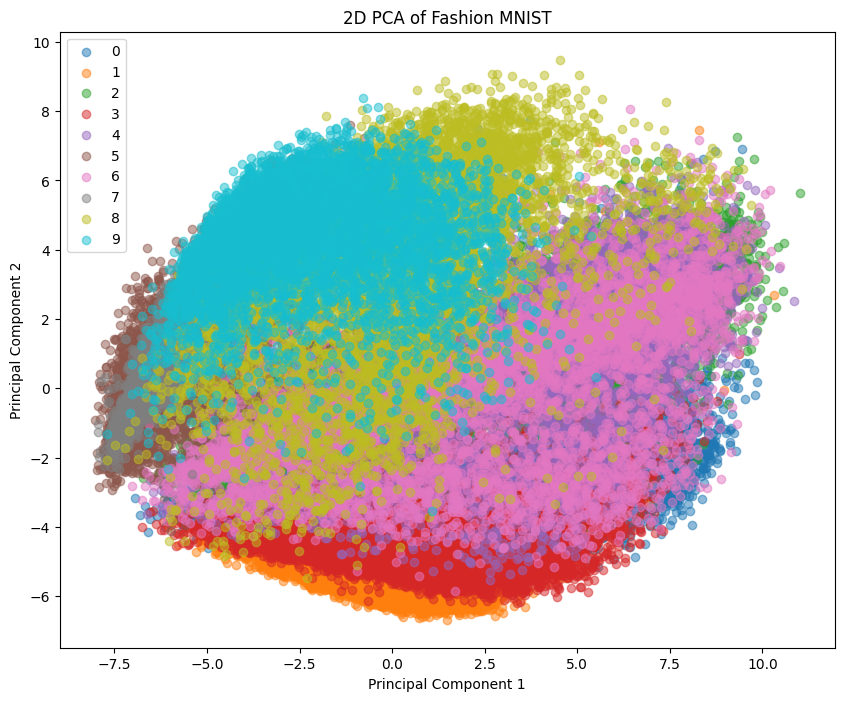

In [18]:
plt.figure(figsize=(10, 8))
for label in unique_labels:
  plt.scatter(X_pca_2[train_labels == label, 0], X_pca_2[train_labels == label, 1], label=label, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Fashion MNIST')
plt.legend()
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

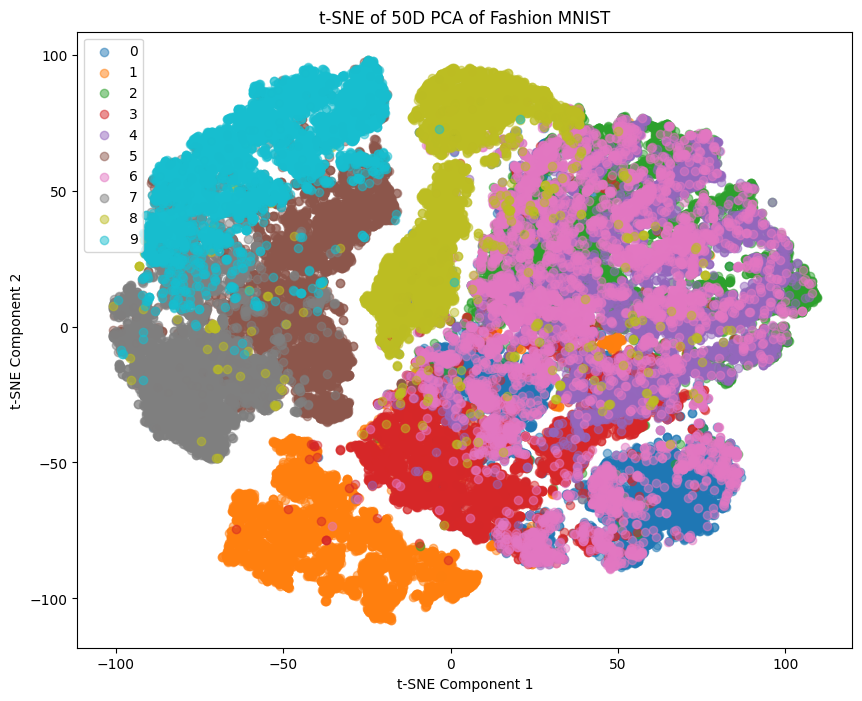

In [19]:
# t-SNE 객체 생성
tsne = TSNE(n_components=2, random_state=42)

# 50차원 데이터를 2차원으로 변환
train_x_tsne = tsne.fit_transform(X_pca_50)

plt.figure(figsize=(10, 8))
for label in unique_labels:
  plt.scatter(train_x_tsne[train_labels == label, 0], train_x_tsne[train_labels == label, 1], label=label, alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of 50D PCA of Fashion MNIST')
plt.legend()
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

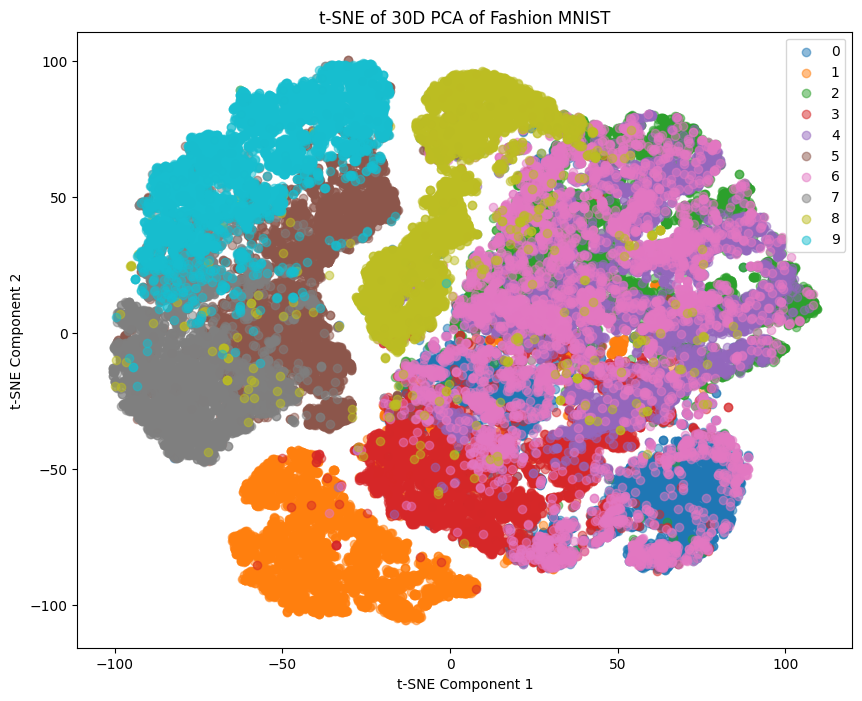

In [20]:
# t-SNE 객체 생성
tsne = TSNE(n_components=2, random_state=42)

# 30차원 데이터를 2차원으로 변환
train_x_tsne_30 = tsne.fit_transform(X_pca_30)

plt.figure(figsize=(10, 8))
for label in unique_labels:
  plt.scatter(train_x_tsne_30[train_labels == label, 0], train_x_tsne_30[train_labels == label, 1], label=label, alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of 30D PCA of Fashion MNIST')
plt.legend()
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [22]:
# DBSCAN 객체 생성
dbscan = DBSCAN(eps=3, min_samples=5)

# 50차원 데이터에 DBSCAN 적용
dbscan_labels = dbscan.fit_predict(X_pca_50)

unqiue_clusters = np.unique(dbscan_labels)

# 군집화 결과 출력
print(f"DBSCAN labels: {unqiue_clusters}")
print(f"클러스터 개수: {len(unqiue_clusters)}")

DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
클러스터 개수: 16


### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [23]:
from sklearn.cluster import KMeans

# KMeans 객체 생성 (군집의 개수는 10개로 설정)
kmeans = KMeans(n_clusters=10, random_state=42)

# 50차원 데이터에 KMeans 적용
kmeans_labels = kmeans.fit_predict(X_pca_50)

unqiue_clusters = np.unique(kmeans_labels)

# 군집화 결과 출력
print(f"KMeans labels: {unqiue_clusters}")
print(f"클러스터 개수: {len(unqiue_clusters)}")

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans labels: [0 1 2 3 4 5 6 7 8 9]
클러스터 개수: 10


### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Li

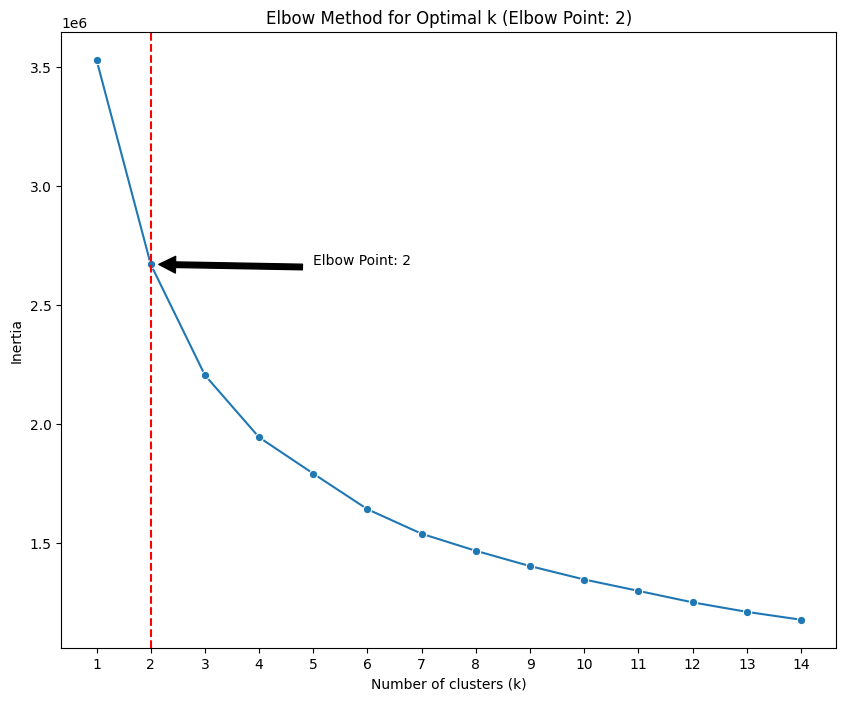

In [28]:
inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_50)
    inertia.append(kmeans.inertia_)

# 엘보우 지점 찾기
def find_elbow_point(inertia):
    # 기울기 계산
    gradients = np.diff(inertia)
    # 기울기 변화 계산
    gradient_changes = np.diff(gradients)
    # 기울기 변화가 가장 큰 지점 찾기
    elbow_point = np.argmax(gradient_changes) + 2  # +2는 인덱스 보정
    return elbow_point

elbow_point = find_elbow_point(inertia)

# 엘보우 메소드 결과 시각화
plt.figure(figsize=(10, 8))
sns.lineplot(x=k_range, y=inertia, marker='o')
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)  # x축 눈금을 정수로 설정
plt.title(f'Elbow Method for Optimal k (Elbow Point: {elbow_point})')

# 엘보우 지점에 화살표 추가
plt.annotate(f'Elbow Point: {elbow_point}', xy=(elbow_point, inertia[elbow_point-1]), 
             xytext=(elbow_point+3, inertia[elbow_point-1]+200),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


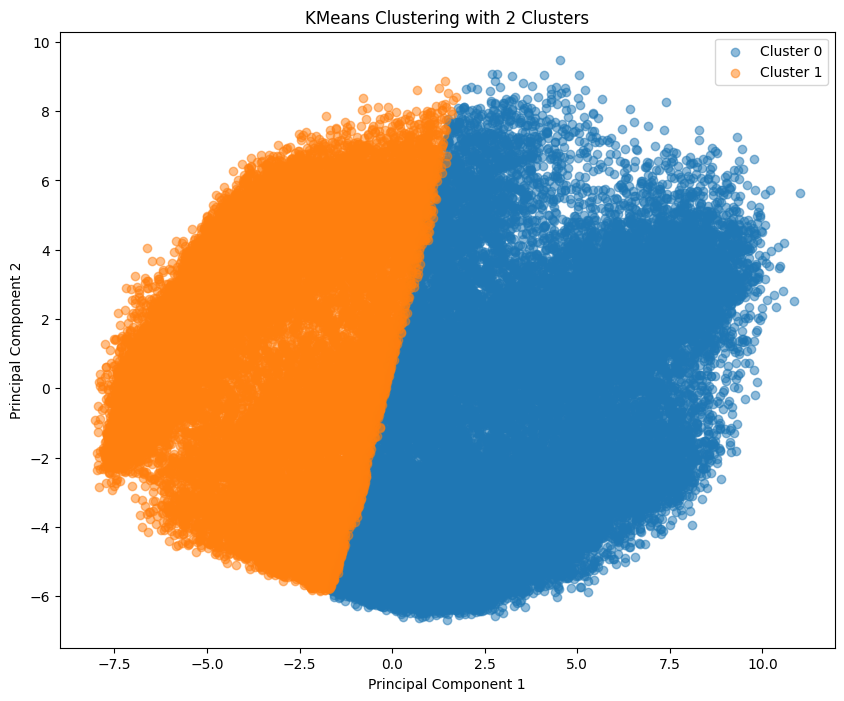

In [29]:
# 최적의 군집 개수로 KMeans 적용
optimal_k = elbow_point
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels_optimal = kmeans_optimal.fit_predict(X_pca_50)

# 군집화 결과 시각화 (2차원으로 축소하여 시각화)
tsne = TSNE(n_components=2, random_state=42)
train_images_tsne = tsne.fit_transform(X_pca_50)

plt.figure(figsize=(10, 8))
for i in range(optimal_k):
  plt.scatter(X_pca_50[kmeans_labels_optimal == i, 0], X_pca_50[kmeans_labels_optimal == i, 1], label=f'Cluster {i}', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'KMeans Clustering with {optimal_k} Clusters')
plt.legend()
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

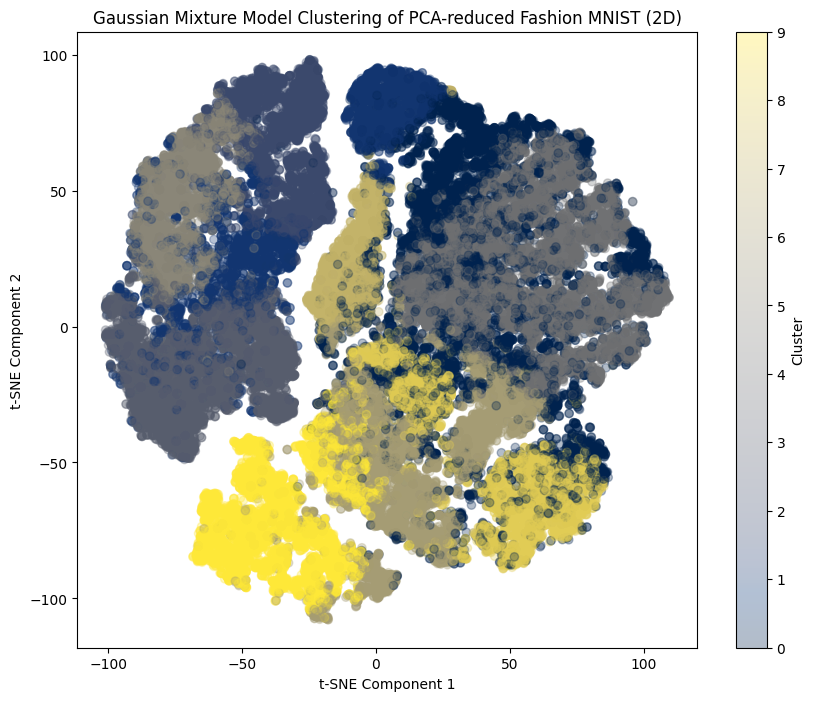

In [31]:
# Gaussian Mixture Model 적용
gmm = GaussianMixture(n_components=10, random_state=42)
gmm_clusters = gmm.fit_predict(X_pca_50)

# t-SNE 적용 (2차원으로 축소하여 시각화)
tsne = TSNE(n_components=2, random_state=42)
train_images_tsne_gmm = tsne.fit_transform(X_pca_50)

# Gaussian Mixture Model 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_gmm[:, 0], train_images_tsne_gmm[:, 1], c=gmm_clusters, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Gaussian Mixture Model Clustering of PCA-reduced Fashion MNIST (2D)')
plt.show()

In [32]:
# Agglomerative Clustering 적용
agg_clustering = AgglomerativeClustering(n_clusters=10) # random_state 옵션 없음
agg_clusters = agg_clustering.fit_predict(X_pca_50)

# t-SNE 적용 (2차원으로 축소하여 시각화)
train_images_tsne_agg = tsne.fit_transform(X_pca_50)

# Agglomerative Clustering 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_agg[:, 0], train_images_tsne_agg[:, 1], c=agg_clusters, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Agglomerative Clustering of PCA-reduced Fashion MNIST (2D)')
plt.show()

MemoryError: unable to allocate array data.

AgglomerativeClustering은 메모리 문제로 학습시키지 못했습니다.

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [35]:
# 실루엣 점수 계산
dbscan_silhouette = silhouette_score(X_pca_50, dbscan_labels)
kmeans_silhouette = silhouette_score(X_pca_50, kmeans_labels_optimal)
# agg_silhouette = silhouette_score(X_pca_50, agg_clusters)
gmm_silhouette = silhouette_score(X_pca_50, gmm_clusters)


print(f"DBSCAN 실루엣 점수: {dbscan_silhouette}")
print(f"K-means 실루엣 점수: {kmeans_silhouette}")
# print(f"Agglomerative Clustering 실루엣 점수: {agg_silhouette}")
print(f"Gaussian Mixture Model 실루엣 점수: {gmm_silhouette}")

DBSCAN 실루엣 점수: -0.30854139156228816
K-means 실루엣 점수: 0.22342262510634073
Gaussian Mixture Model 실루엣 점수: 0.10302873454697248


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

실루엣 점수는 클러스터링 성능을 평가하는 중요한 지표 중 하나입니다. 이 점수는 -1에서 1 사이의 값을 가지며, 값이 클수록 클러스터의 품질이 좋음을 나타냅니다.

DBSCAN: 실루엣 점수가 -0.3085로, 이는 데이터 포인트들이 잘못된 클러스터에 속해 있거나 클러스터 간의 경계가 불분명하다는 것을 의미합니다. 음수의 점수는 클러스터 간의 분리가 좋지 않다는 것을 나타냅니다.

K-means: 실루엣 점수가 0.2234로, 이는 양수이지만 상대적으로 낮은 값입니다. K-means 알고리즘은 클러스터 간의 거리가 어느 정도 유지되고 있음을 의미하지만, 여전히 개선의 여지가 있다는 것을 보여줍니다.

Gaussian Mixture Model (GMM): 실루엣 점수가 0.1030으로, K-means보다도 낮은 성능을 보입니다. 이는 GMM이 클러스터를 잘 구분하지 못하고 있다는 것을 나타냅니다.

종합적으로 볼 때, 세 모델 모두 클러스터링 성능이 높지 않으며, 특히 DBSCAN은 가장 낮은 성능을 보이고 있습니다. K-means가 상대적으로 가장 나은 성능을 나타내지만, 여전히 개선이 필요합니다. 데이터의 분포나 클러스터 수를 조정하거나, 다른 클러스터링 알고리즘을 시도해 볼 필요가 있습니다.